In [10]:
import numpy as np
from sklearn import base, metrics
from sklearn.model_selection import KFold
import pandas as pd
from classifiers import *
from data_generation import *

## Data Viz

In [2]:
## Number of dimensions and classes
k = 3

## Number of data points
n = 1000

In [3]:
X,y = generate_simplex_data(k,n)

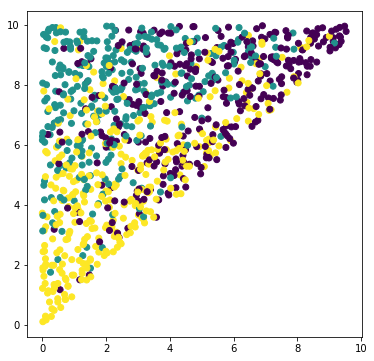

In [5]:
## Visualize Data Set
from matplotlib import pyplot as plt
fig=plt.figure(figsize=(6,6))
plt.scatter([X[:, 0]], [X[:, 1]], c=y.T)

## Metrics and Code Needed to Perform Tests

In [6]:
def weighted_absolute_loss(u, y, alpha):
    y = np.array(y.T[0]) ## y is given as a column matrix, but predictions are not
    zs = np.zeros_like(y)
    return np.mean((1 - alpha) * np.maximum((u - y), zs) + alpha * np.maximum((y - u), zs))

In [7]:
def compute_alpha_quantile(X, alpha):
    n = X.shape[0]
    y = np.zeros((n, 1))
    w_alpha = alpha * 10 ## Simplex weighted to be 10 x 10
    for i in range(0, n):
        curr_vec = X[i,:]
        
        if(w_alpha < curr_vec[0]):
            y[i, 0] = 0
        elif(w_alpha  > curr_vec[-1]):
            y[i,0] = k - 1
        else:
            y[i,0] = np.argmax(curr_vec > w_alpha)
    return y

## Cross-Validation (Small Scale)

In [9]:
k = 3
n = 1000
a1, a2, a3 = 0.3, 0.5, 0.75

X_train,y_train = generate_simplex_data(k,n)
y_train = y_train.astype(int)

X_test,y_test = generate_simplex_data(k,n)

In [22]:
## Cross Validation for rbf and polynomial kernel
quantiles = [a1, a2, a3]

reg_vals = [10**(-2), 10**(-1), 10**0, 10**1]
q_vals = [2, 3, 4, 5]
gamma_vals = [10**(-1), 10**0, 10**1, 10**2]

cv_results = pd.DataFrame(columns=['Fold', 'Quantile', 'Surrogate', 
                                   'Kernel_Type', 'Kernel_Parameter', 'Regularization', '01_Loss'])

kf = KFold(n_splits=2)
kf.get_n_splits(X_train)
fold = 0
for train_index, test_index in kf.split(X_train):
    fold += 1
    curr_X_train, curr_X_test = X_train[train_index], X_train[test_index]
    curr_y_train, curr_y_test = y_train[train_index], y_train[test_index]
    for a in quantiles:
        print('Fold ' + str(fold) + ' Quantile ' + str(a))
        a_test_quantiles = compute_alpha_quantile(curr_X_test, a)
        for reg in reg_vals:
            for q in q_vals:
                clf1 = LogisticQuantileIT(gamma=a, alpha=1., kernel_type='poly', kernel_param=q)
                clf1.fit(curr_X_train, curr_y_train)
                lossIT = metrics.zero_one_loss(clf1.predict(curr_X_test), a_test_quantiles , normalize=False)
                result = {'Fold': fold, 'Quantile': a, 'Surrogate': 'IT', 'Kernel_Type': 'poly', 
                          'Kernel_Parameter': q, 'Regularization': reg, '01_Loss': lossIT}
                cv_results = cv_results.append(result, ignore_index=True)

                clf2 = LogisticQuantileAT(gamma=a, alpha=1., kernel_type='poly', kernel_param=q)
                clf2.fit(curr_X_train, curr_y_train)
                lossAT = metrics.zero_one_loss(clf2.predict(curr_X_test), a_test_quantiles , normalize=False)
                result = {'Fold': fold, 'Quantile': a, 'Surrogate': 'AT', 'Kernel_Type': 'poly', 
                          'Kernel_Parameter': q, 'Regularization': reg, '01_Loss': lossAT}
                cv_results = cv_results.append(result, ignore_index=True)
                
            for g in gamma_vals:
                clf1 = LogisticQuantileIT(gamma=a, alpha=1., kernel_type='rbf', kernel_param=g)
                clf1.fit(curr_X_train, curr_y_train)
                lossIT = metrics.zero_one_loss(clf1.predict(curr_X_test), a_test_quantiles , normalize=False)
                result = {'Fold': fold, 'Quantile': a, 'Surrogate': 'IT', 'Kernel_Type': 'rbf', 
                          'Kernel_Parameter': g, 'Regularization': reg, '01_Loss': lossIT}
                cv_results = cv_results.append(result, ignore_index=True)

                clf2 = LogisticQuantileAT(gamma=a, alpha=1., kernel_type='rbf', kernel_param=g)
                clf2.fit(curr_X_train, curr_y_train)
                lossAT = metrics.zero_one_loss(clf2.predict(curr_X_test), a_test_quantiles , normalize=False)
                result = {'Fold': fold, 'Quantile': a, 'Surrogate': 'AT', 'Kernel_Type': 'rbf', 
                          'Kernel_Parameter': g, 'Regularization': reg, '01_Loss': lossAT}
                cv_results = cv_results.append(result, ignore_index=True)
    

Fold 1 Quantile 0.3


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 1 Quantile 0.5
Fold 1 Quantile 0.75
Fold 2 Quantile 0.3
Fold 2 Quantile 0.5
Fold 2 Quantile 0.75


## Tests

In [9]:
def train_classifiers(X_train, y_train, X_test, y_test, a_vals, degrees, gammas):
    
    return results

### Plot Decision Boundaries

In [ ]:
curr = results_linear_a2
for clf in curr.keys():
    print(clf)    
    fig=plt.figure(figsize=(6,6))
    plt.scatter([X_test[:, 0]], [X_test[:, 1]], c=[clf.predict(X_test).T])
    plt.show()

In [ ]:
y_quantiles = compute_alpha_quantile(X_test, a2).astype(int)
fig=plt.figure(figsize=(6,6))
plt.scatter([X_test[:, 0]], [X_test[:, 1]], c=y_quantiles.T)